# Sum of sinusoids benchmark for e-prop

## Goal: Shape random noise/spikes into target sum of sinusoids function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# from torchvision.datasets import MNIST
# from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import snntorch as snn 
from snntorch import spikegen
# from snntorch.spikevision import spikedata
import snntorch.spikeplot as splt

import tonic
from tonic import transforms

## Set useful parameters

In [2]:
params= {
    'dtype'     : torch.float32,
    'n_batch'     : 1,             # batch size of the testing set
    'n_out'       : 1,             # number of output neurons (number of target curves)
    'n_in'        : 100 ,          # number of input units
    'n_rec'       : 100,           # number of recurrent units

    'f0'          : 50 ,           # input firing rate
    'reg_rate'    : 10 ,           # target rate for regularization

    'n_iter'      : 2000 ,         # number of iterations/epochs
    'seq_len'     : 1000  ,         # number of time steps per sequence
    'print_every' : 10  ,          # print statistics every K iterations

    'dampening_factor' : 0.3,      # dampening factor to stabilize learning in RNNs
    'learning_rate'  : 1e-4,       # learning rate
    'reg'         : 300,           # regularization coefficient

    'dt'          : 1. ,           # (ms) simulation step
    'thr'         : 0.03,          # threshold at which the LSNN neurons spike (in arbitrary units)

    'do_plot'     : True,          # interactive plots during training
    'random_feedback' : False,     # use random feedback if true, otherwise take the symmetric of the readout weights
    'stop_z_gradients' : True,    # stop gradients in the model dynamics to get mathematical equivalence between eprop and BPTT
    'gradient_check' : True,       # verify that the gradients computed with e-prop match the gradients of BPTT
    'eprop_or_bptt' : 'eprop',     # choose the learing rule, it should be `eprop` of `bptt`'
    }

# explicitate some of the parameters to lighten syntax
dtype = params['dtype']

# Experiment parameters
dt = 1  # time step in ms
input_f0 = params['f0'] / 1000  # input firing rate in kHz in coherence with the usage of ms for time
regularization_f0 = params['reg_rate'] / 1000  # desired average firing rate in kHz
tau_m = tau_m_readout = 30
thr = params['thr']
params['tau_m'] = tau_m
params['tau_m_readout'] = tau_m_readout
params['regularization_f0'] = regularization_f0

## Generate training sinusoids

In [3]:
def sum_of_sines_target(seq_len, n_sines=4, periods=[1000, 500, 333, 200], weights=None, phases=None, normalize=True):
    '''
    Generate a target signal as a weighted sum of sinusoids with random weights and phases.
    :param n_sines: number of sinusoids to combine
    :param periods: list of sinusoid periods
    :param weights: weight assigned the sinusoids
    :param phases: phases of the sinusoids
    :return: one dimensional vector of size seq_len contained the weighted sum of sinusoids
    '''
    if periods is None:
        periods = [np.random.uniform(low=100, high=1000) for i in range(n_sines)]
    assert n_sines == len(periods)
    sines = []
    weights = np.random.uniform(low=0.5, high=2, size=n_sines) if weights is None else weights
    phases = np.random.uniform(low=0., high=np.pi * 2, size=n_sines) if phases is None else phases
    for i in range(n_sines):
        sine = np.sin(np.linspace(0 + phases[i], np.pi * 2 * (seq_len // periods[i]) + phases[i], seq_len))
        sines.append(sine * weights[i])

    output = sum(sines)
    if normalize:
        output = output - output[0]
        scale = max(np.abs(np.min(output)), np.abs(np.max(output)))
        output = output / np.maximum(scale, 1e-6)
    return output

In [4]:
# build the output pattern (note that the [None,:] adds an extra dimension of size 1 to the tensor)
# dimentions: [batch=1, time_steps=1000, neurons=1]
target_sinusoidal_outputs = [sum_of_sines_target(params['seq_len'])[None, :] for i in range(params['n_out'])]
target_sinusoidal_outputs = torch.from_numpy(np.stack(target_sinusoidal_outputs, axis=2)).type(dtype=params["dtype"])
print(f"target_sinusoidal_outputs shape: {target_sinusoidal_outputs.shape}")

target_sinusoidal_outputs shape: torch.Size([1, 1000, 1])


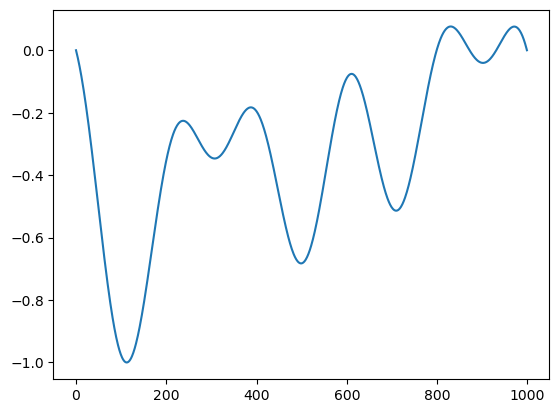

In [5]:
# Visualise first example in batch
plt.plot(target_sinusoidal_outputs[0])

In [6]:
# Generate random input spikes
# dimentions: [batch=1, time_steps=1000, n_in=100]
frozen_poisson_noise_input = np.random.rand(params['n_batch'], params['seq_len'], params['n_in']) < dt * input_f0  # why sampling period * input frequency? = [spikes]
input_spikes = torch.from_numpy(frozen_poisson_noise_input).type( dtype=dtype )
print(input_spikes.shape)

torch.Size([1, 1000, 100])


Text(0.5, 1.0, 'Spike train for 0th input')

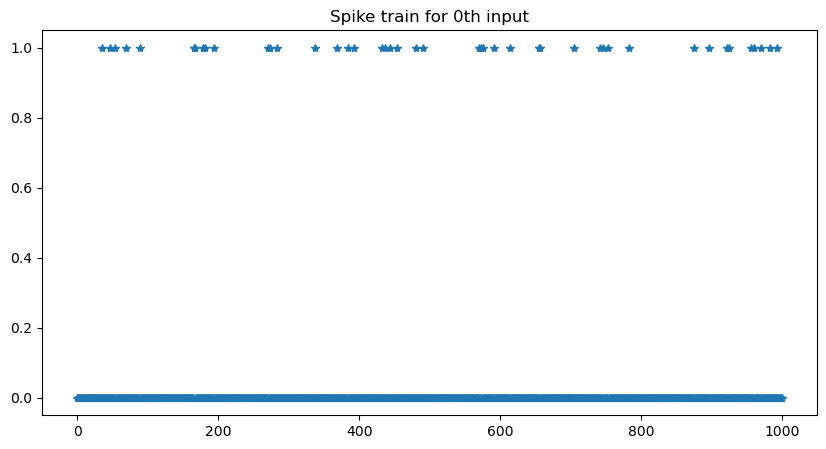

In [7]:
plt.figure(figsize=(10,5))
plt.plot(input_spikes[0, :, 0], "*")
plt.title("Spike train for 0th input")

### Create DataLoader

`TODO:`

## Define Network

For now, feed each frame one by one to network, flattening the polarities (ON and OFF events)

In [8]:
TAU_MEM = tau_m  # 500 ms
TAU_OUT = tau_m_readout  # 20 ms
GAMMA = params["dampening_factor"]
DT = 1  # 1s TODO: Find appropriate time constants and timestep size
THRESHOLD = params["thr"]
NUM_STEPS = params["seq_len"]  

NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
NUM_RECS= 64  # Design choice, number of recurrent neurons
NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
CLASSIFICATION = False  # True: Classification, False: Regression
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NUM_INPUTS: 100, NUM_HIDDENS: 64, NUM_OUTPUTS: 1


In [9]:
TAU_MEM = 20e-3  # 50 ms
TAU_OUT = 20e-3  # 20 ms
GAMMA = 0.3
DT = 1e-3  # 1s TODO: Find appropriate time constants and timestep size
THRESHOLD = 1.0
NUM_STEPS = params["seq_len"]

NUM_INPUTS = input_spikes.shape[-1]  # [BS, timesteps, neurons]
NUM_RECS= 64  # Design choice, number of recurrent neurons
NUM_OUTPUTS = target_sinusoidal_outputs.shape[-1]  # Number of output neurons
CLASSIFICATION = False
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_RECS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NUM_INPUTS: 100, NUM_HIDDENS: 64, NUM_OUTPUTS: 1


## Hardcoded network

In [10]:
# Define pseudo-derivative to tackle non-differentiability of the spike function

class SpikeFunction(torch.autograd.Function):
    """Applies Heaviside function in forward pass,
    and pseudo-derivative in backward pass.
    """
    @staticmethod
    def forward(ctx, input: torch.Tensor, threshold: float, damping_factor: float = 0.3):
        """Forward pass: compute activation for each input element (voltage).
        Parameters:
            ctx: context object to stash information for backward pass.
            input: input tensor (membrane voltages)
            threshold: firing threshold
            damping_factor: damping factor for pseudo-derivative
        Returns:
            output tensor (spikes)
        """
        ctx.save_for_backward(input)
        ctx.threshold = threshold  # threshold is not a Tensor
        ctx.damping_factor = damping_factor
        return input.gt(threshold).float()

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        input, = ctx.saved_tensors
        threshold, damping_factor = ctx.threshold, ctx.damping_factor
        grad_input = None

        if ctx.needs_input_grad[0]:
            pseudo_deriv = damping_factor * torch.maximum(torch.tensor([0]), 1-torch.abs(input/threshold))
            # Element-wise multiplication
            grad_input = grad_output.mul(pseudo_deriv)
        return grad_input, None, None

In [11]:
import torch.nn.functional as F

class RSNN(nn.Module):
    """Simple RSNN as in e-prop paper.
    I.e. Inputs -> Recurrent LIF Neurons -> Output LIF Neurons
    """
    def __init__(self, num_inputs: int, num_rec: int, num_outputs: int, classification: bool, 
            tau_mem: float, tau_out: float, dt, gamma: float, threshold: float, 
            device, num_timesteps=3, w_init_gain: list[float]=[1.0, 1.0, 1.0]):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from torch.nn.Module

        self.device = device

        # Hyperparams
        self.tau_mem = tau_mem                  # Decay time constant for recurrent membrane potentials
        self.tau_out = tau_out                  # Decay time constant for output membrane potentials
        self.dt = dt                            # Timestep size
        self.alpha = np.exp(-dt/tau_mem)        # Recurrent membrane potential decay rate
        self.gamma = gamma                      # Constant in pseudo-deriv
        self.kappa = np.exp(-dt/tau_out)        # Output membrane potential decay rate
        self.threshold = threshold              # Membrane voltage threshold

        self.T = num_timesteps                  # Number of timesteps per example (3 for NMNIST saccades)

        # Architecture params
        self.n_in = num_inputs
        self.n_rec = num_rec
        self.n_out = num_outputs
        self.classification = classification

        # Declare network weights
        self.w_in = nn.Parameter(torch.Tensor(self.n_rec, self.n_in))
        self.w_rec = nn.Parameter(torch.Tensor(self.n_rec, self.n_rec))
        self.w_out = nn.Parameter(torch.Tensor(self.n_out, self.n_rec))
        self.output_bias = 0.  # TODO: Add output bias, should this be a vector?

        # w_init_gain = [0.5, 0.1, 0.5]
        self.init_params(w_init_gain)

    def init_params(self, gain):
        """Perform He Initialisation on network parameters"""
        # nn.init.kaiming_normal_(self.w_in, mode="fan_in", nonlinearity="relu")
        # self.w_in.data *= gain[0]
        # nn.init.kaiming_normal_(self.w_rec, mode="fan_in", nonlinearity="relu")
        # self.w_rec.data += gain[1]
        # nn.init.kaiming_normal_(self.w_out, mode="fan_in", nonlinearity="relu")
        # self.w_out.data += gain[2]

        # Try Xavier init with scale rel to decay rate
        weight_scale = 1 - self.alpha  # Can multiply this as well

        nn.init.normal_(self.w_in, mean=0, std=np.sqrt(self.n_in))
        nn.init.normal_(self.w_rec, mean=0, std=weight_scale/np.sqrt(self.n_rec))
        nn.init.normal_(self.w_out, mean=0, std=weight_scale/np.sqrt(self.n_rec))


    
    def reset_network(self):
        """Set membrane potentials, spikes, and gradients to zero.
        Used after feeding in an example, to prepare for next.
        """
        # Recurrent hidden state and output spikes
        self.v = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)
        self.z = torch.zeros(self.T, self.BS, self.n_rec).to(self.device)

        # Output hidden state
        self.vo = torch.zeros(self.T, self.BS, self.n_out).to(self.device)
        # TODO: Can use output spikes as well

        # Gradients
        self.w_in.grad = torch.zeros_like(self.w_in)
        self.w_rec.grad = torch.zeros_like(self.w_rec)
        self.w_out.grad = torch.zeros_like(self.w_out)

    def forward(self, x: torch.Tensor):
        """Feed example through RSNN
        Parameters:
            x: Inputs to RSNN, [T, BS, features...]
        Returns:
            yo: Output probabilities, [T, BS, num_outputs]
            vo: Output membrane potentials, [T, BS, num_outputs]
        """

        # Extract batch size and flatten x features
        self.BS= x.shape[1]  # x shape: [T, BS, features...]
        # x = x.flatten(start_dim=2)  # Flatten after [time, batch_size, ...]

        # Reset membrane potentials and gradients
        self.reset_network()

        # Ensure no self connections
        self.w_rec *= (1 - torch.eye(self.n_rec, self.n_rec, device=self.device))

        # Debug
        # print(f"v: {self.v.shape}, v[t]: {self.v[0].shape}")
        # print(f"x: {x.shape}, x[t]: {x[0].shape}")

        for t in range(self.T - 1):
            self.v[t+1] = self.alpha*self.v[t] + self.z[t].mm(self.w_rec.t()) + x[t].mm(self.w_in.t()) - self.z[t]*self.threshold  # z[t], x[t] row vectors, i.e. [1, N_REC]
            # print(f"self.z[t].mm(self.w_rec.t()): {self.z[t].mm(self.w_rec.t()).shape}")
            # print(f"x[t].mm(self.w_in.t()): {x[t].mm(self.w_in.t()).shape}")
            # print(f"self.v[t+1]: {self.v[t+1].shape}")

            # self.z[t+1] = (self.v[t+1] > self.threshold).float()
            self.z[t+1] = SpikeFunction.apply(self.v[t+1], self.threshold, self.gamma)
            
            # print(f"self.z[t+1]: {self.z[t+1].shape}")
            # print(f"self.z[t].mm(self.w_out.t()): {self.z[t].mm(self.w_out.t()).shape}")
            self.vo[t+1] = self.kappa*self.vo[t] + self.z[t].mm(self.w_out.t()) + self.output_bias
        
        # Apply softmax for classification
        if self.classification:
            self.yo = F.softmax(self.vo, dim=2)  # vo shape: [T, BS, num_outputs]
        else:  # Regression on membrane voltage
            self.yo = self.vo

        return self.yo, self.vo
    
    def calc_loss(self, vo, y_target):
        """Calculate model loss (using output membrane potentials)

        Parameters:
            vo: Output membrane potentials [T, BS, NUM_OUTPUTS]
            y_target: In case of CE loss, index of correct class (not one-hot),
                        size, [BATCH_SIZE].
                        If MSE, target regression value, size [T, BS, n_out]
        Returns:
            loss_val: scalar
        
        N.B. Usually must y_target.swapaxes(1,0) before passing to this method,
        since dataloader will give [BS, T, ...]
        
        """
        # print(f"vo: {vo.shape}")
        # print(f"y_target: {y_target.shape} should be {[1]}")
        # print(f"CELoss: {F.mse_loss(vo[0], y_target[0, :, :]).shape}")
        loss_val = torch.zeros((1), dtype=float, device=self.device)
        for t in range(self.T):
            if self.classification:
                loss_val += F.cross_entropy(vo[t], y_target)
            else:
                loss_val += F.mse_loss(vo[t], y_target[t, :, :])
        return loss_val.item()

    
    def set_grads(self, x: torch.Tensor, yo: torch.Tensor, y_target: torch.Tensor):
        """Calculate learning signals, eligility traces and set .grad attributes"""

        # Surrogate derivative, N.B. gamma is gamma_d/v_th
        psi = self.gamma*torch.max(torch.zeros_like(self.v), 1-torch.abs((self.v-self.threshold)/self.threshold))

        # Pseudocode:
        # eligibility_vectors = low pass filtered inputs
        # eligibility_traces = psi * eligibility_vectors
        # Gradients = Learning signal * eligibility_traces

        # Eligibility traces for input and reccurent weights
        alpha_conv  = torch.tensor([self.alpha ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_in    = F.conv1d(x.permute(1,2,0), alpha_conv.expand(self.n_in ,-1,-1), padding=self.T, groups=self.n_in )[:,:,1:self.T+1].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_in , n_t 
        elig_trace_in    = torch.einsum('tbr,brit->brit', psi, elig_vec_in)                                                                                                                          #n_b, n_rec, n_in , n_t 
        elig_vec_rec   = F.conv1d(self.z.permute(1,2,0), alpha_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:, :self.T].unsqueeze(1).expand(-1,self.n_rec,-1,-1)  #n_b, n_rec, n_rec, n_t
        elig_trace_rec   = torch.einsum('tbr,brit->brit', psi, elig_vec_rec)

        # Eligibility vectors for output weights
        kappa_conv = torch.tensor([self.kappa ** (self.T-i-1) for i in range(self.T)]).float().view(1,1,-1).to(self.device)
        elig_vec_out = F.conv1d(self.z.permute(1,2,0), kappa_conv.expand(self.n_rec,-1,-1), padding=self.T, groups=self.n_rec)[:,:,1:self.T+1]

        # Low pass filtered eligibility traces for input and recurrent weights
        e_bar_in = F.conv1d(elig_trace_in.reshape(self.BS, self.n_in *self.n_rec, self.T), kappa_conv.expand(self.n_in*self.n_rec,-1,-1), padding=self.T, groups=self.n_in *self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_in ,self.T)   #n_b, n_rec, n_in , n_t
        e_bar_rec = F.conv1d(elig_trace_rec.reshape(self.BS,self.n_rec*self.n_rec,self.T), kappa_conv.expand(self.n_rec*self.n_rec,-1,-1), padding=self.T, groups=self.n_rec*self.n_rec)[:,:,1:self.T+1].reshape(self.BS,self.n_rec,self.n_rec,self.T)   #n_b, n_rec, n_rec, n_t

        # Learning signals
        # TODO: yo is for every timestep, y_target needs to be for every time, and one-hot coded [T, BS, NUM_OUT]
        if self.classification:
            y_target = F.one_hot(y_target.long(), num_classes=self.n_out)
        error = yo - y_target
        L = torch.einsum('tbo,or->brt', error, self.w_out)

        # TODO: Only compute network updates on timestepswhen target is present?

        # Update weight .grad attributes
        # TODO: Make learning rate adaptable? But learning rate should be handled by optimzer, this is just grad
        self.w_in.grad  += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_in ,-1) * e_bar_in , dim=(0,3)) 
        self.w_rec.grad += torch.sum(L.unsqueeze(2).expand(-1,-1,self.n_rec,-1) * e_bar_rec, dim=(0,3))
        self.w_out.grad += torch.einsum('tbo,brt->or', error, elig_vec_out)

net = RSNN(num_inputs=NUM_INPUTS,
           num_rec=NUM_RECS,
           num_outputs=NUM_OUTPUTS,
           classification=CLASSIFICATION,
           tau_mem=TAU_MEM,
           tau_out=TAU_OUT,
           dt=DT,
           gamma=GAMMA,
           threshold=THRESHOLD,
           device=device,
           num_timesteps=params["seq_len"],
).to(device)

In [12]:
net.alpha, net.kappa

(0.951229424500714, 0.951229424500714)

In [13]:
net.w_rec.sum(dim=1)

tensor([ 0.0619, -0.0589,  0.0565,  0.0088,  0.0541, -0.0219,  0.0591, -0.0080,
        -0.0843, -0.0277,  0.0637, -0.0360, -0.0558,  0.0092,  0.0757, -0.0278,
         0.0008, -0.0055,  0.0346,  0.0403,  0.0331,  0.0537, -0.0547,  0.0404,
        -0.0180,  0.0026,  0.0297, -0.0054,  0.0441, -0.0423,  0.0315,  0.0286,
        -0.0382,  0.0783, -0.0256,  0.0358, -0.0064, -0.0477, -0.0414, -0.0412,
         0.0444,  0.0089,  0.0411,  0.0182,  0.0117, -0.0380,  0.0661,  0.0854,
        -0.0455, -0.0703, -0.0321,  0.0043,  0.0127,  0.0349, -0.0001, -0.0830,
         0.0459,  0.0334,  0.0186,  0.0577,  0.0192,  0.0118, -0.0381,  0.0552],
       grad_fn=<SumBackward1>)

## Define accuracy metrics

In [14]:
def train_printer(epoch, loss_hist):
    print(f"Epoch {epoch}")
    print(f"Train Set Loss: {loss_hist[epoch]:.2f}")
    print("\n")

## Debug: single epoch of training

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [16]:
with torch.no_grad():

    data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
    data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

    # Forward pass
    preds, vo = net(data)

    # Backward pass
    loss = net.calc_loss(vo, targets)
    print(f"Loss before training: {loss}")
    optimizer.zero_grad(set_to_none=False)
    net.set_grads(data, preds, targets)
    optimizer.step()

Loss before training: 1037.1722770725028


In [17]:
with torch.no_grad():
    preds, vo = net(data)
    loss = net.calc_loss(vo, targets)
    print(f"Loss after training: {loss}")


Loss after training: 920.3076064151865


In [18]:
target_sinusoidal_outputs.shape, targets.shape, vo.shape

(torch.Size([1, 1000, 1]), torch.Size([1000, 1, 1]), torch.Size([1000, 1, 1]))

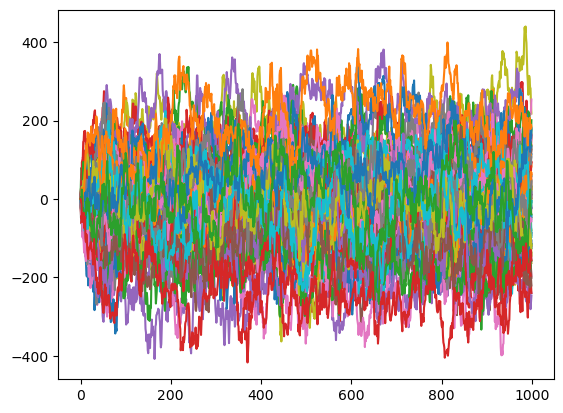

In [19]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.v[:,0])

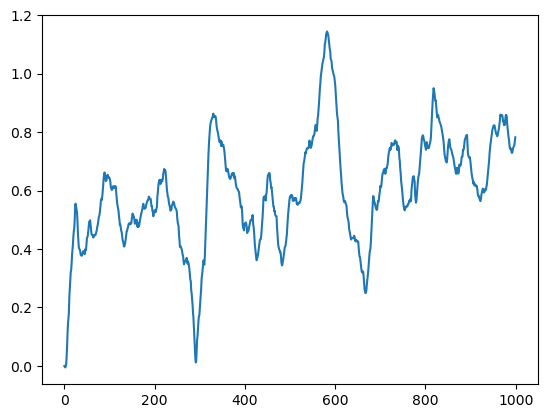

In [20]:
fig, axs = plt.subplots(1,1)
# axs.plot(target_sinusoidal_outputs[0])
axs.plot(net.vo[:,0])

In [21]:
net.w_in.sum(dim=1)

tensor([   1.0752,   93.4311,  -30.2329, -111.9021,    7.4520, -135.4829,
          15.2686,   19.5389,  212.1378,  -19.9993,  -78.6557,   15.5125,
         118.5153,   81.2647, -193.2095,  -38.9758,  138.5464,   21.5295,
        -128.3773,  -83.9889,   95.6443,   44.3821,   99.0951,  146.6272,
           9.9365,   41.8592, -224.2048,   10.8250,  -16.3933,  -13.2362,
         -81.6322,  -35.7042,  170.8775,   -6.8952,  230.1688, -115.0332,
        -104.1908,  -96.9894,  -56.3570,   -2.2975,  189.0121,   31.6738,
         -69.9663,   56.2737, -188.7103,   46.5840,   57.7296,   85.1738,
           7.0822,   96.5126, -114.7170,    2.1868, -174.8287, -115.5825,
         -59.6875, -115.7605,   44.9331,   12.6725,    5.8392,  -28.4453,
          86.1851,  228.2355,    1.2411, -230.3434], grad_fn=<SumBackward1>)

## Training loop

Note slightly strange example:
- Our training set consists only of 1 example, (input_spikes, target_sinusoids)
- We shall train for 100 epochs on this example
- We then test on that example

In [22]:
print(input_spikes.shape, target_sinusoidal_outputs.shape)

torch.Size([1, 1000, 100]) torch.Size([1, 1000, 1])


In [23]:
LR = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [24]:
net

RSNN()

In [25]:
NUM_EPOCHS = 50
PRINT_EVERY_EPOCHS = 10
train_loss_hist = []
with torch.no_grad():
    # Outer training loop
    for epoch in range(NUM_EPOCHS):
        # for data, targets in iter(dataloader))
        net.train()
        data, targets = input_spikes, target_sinusoidal_outputs  # would be next(iter(dataloader))
        data, targets = data.swapaxes(1, 0), targets.swapaxes(1,0)

        # Forward pass
        preds, vo = net(data)

        # Backward pass
        optimizer.zero_grad(set_to_none=False)
        loss = net.calc_loss(vo, targets)
        net.set_grads(data, preds, targets)
        optimizer.step()

        # Store loss
        train_loss_hist.append(loss)

        # Print training statistics
        if epoch % PRINT_EVERY_EPOCHS == 0:
            train_printer(epoch, train_loss_hist)

Epoch 0
Train Set Loss: 920.31


Epoch 10
Train Set Loss: 178.16


Epoch 20
Train Set Loss: 67.30


Epoch 30
Train Set Loss: 85.28


Epoch 40
Train Set Loss: 58.16


Epoch 50
Train Set Loss: 54.48


Epoch 60
Train Set Loss: 50.64




KeyboardInterrupt: 

## Plot results

### Learning curves

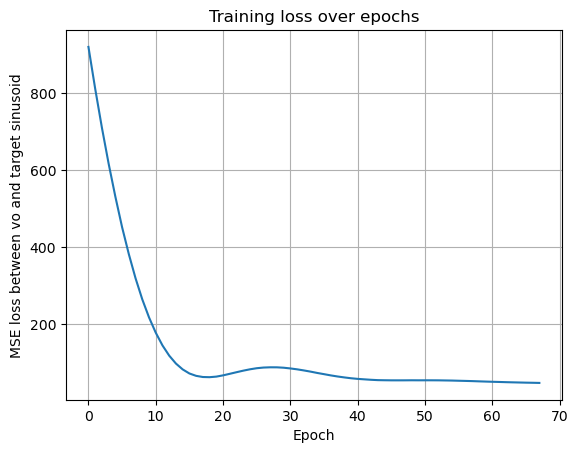

In [26]:
plt.title("Training loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE loss between vo and target sinusoid")
plt.plot(train_loss_hist)
# plt.ylim((0, 300))
plt.grid()

In [ ]:
len(train_loss_hist)

1000

### Output membrane voltage

In [ ]:
net.vo.shape, target_sinusoidal_outputs.shape

(torch.Size([1000, 1, 1]), torch.Size([1, 1000, 1]))

Text(0, 0.5, 'Membrane voltage')

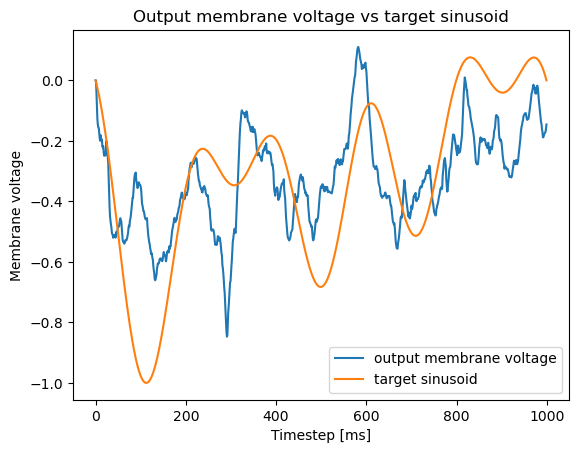

In [27]:
plt.plot(net.vo[:,0,0], label="output membrane voltage")
plt.plot(target_sinusoidal_outputs[0,:,0], label="target sinusoid")
plt.legend()
plt.title("Output membrane voltage vs target sinusoid")
plt.xlabel("Timestep [ms]")
plt.ylabel("Membrane voltage")

## Probe network

### Plot recurrent membrane potentials

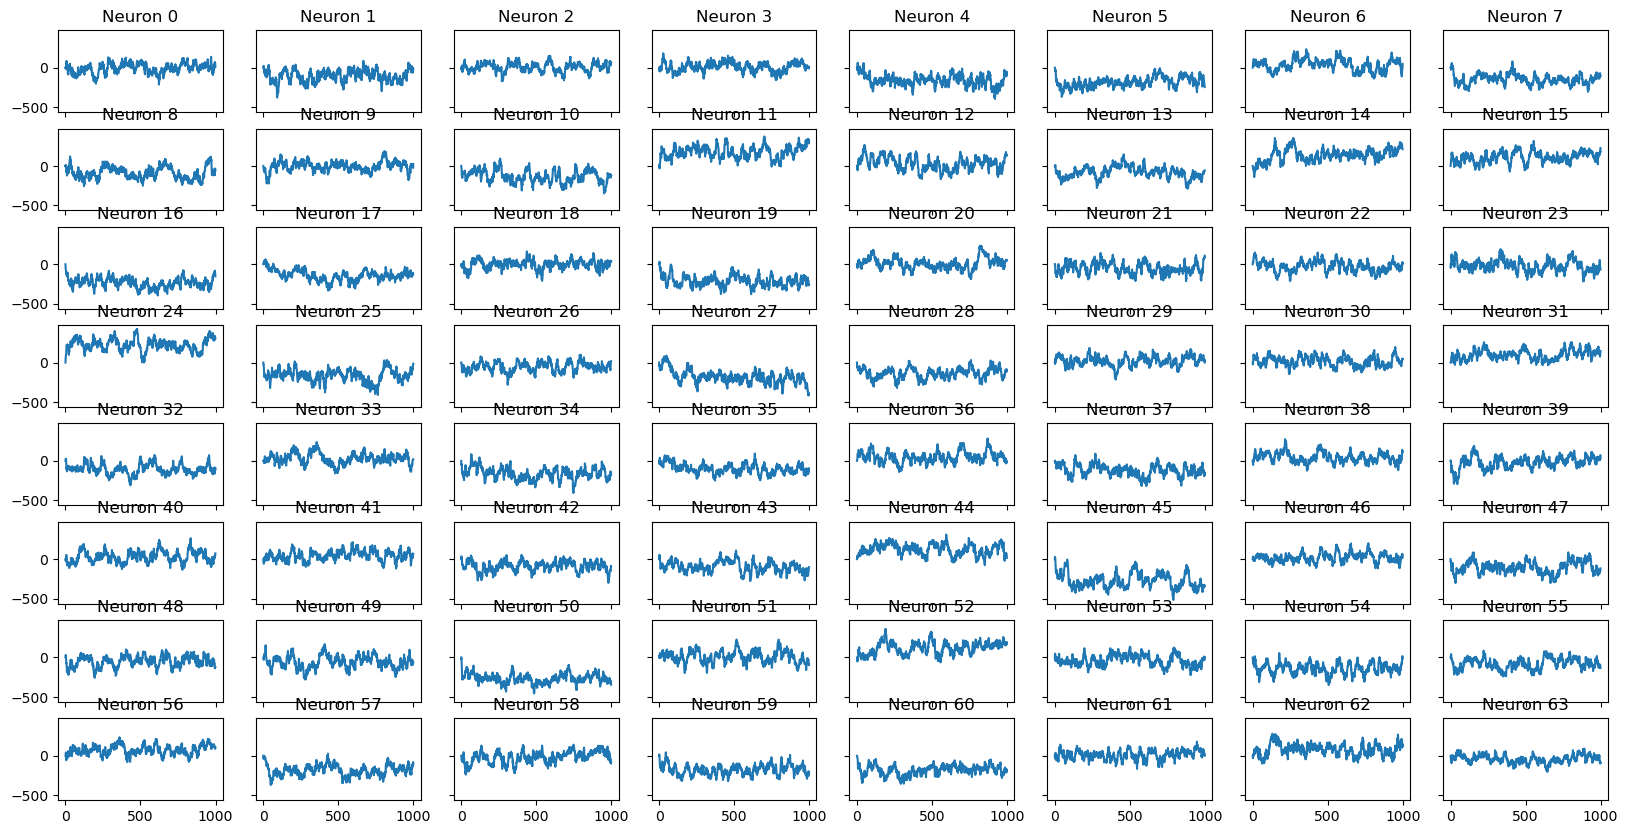

In [ ]:
# Plot membrane voltage for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.v[:,0,i*8+j], label="output membrane voltage")
        axs[i,j].set_title(f"Neuron {i*8+j}")
        # axs[i,j].legend()

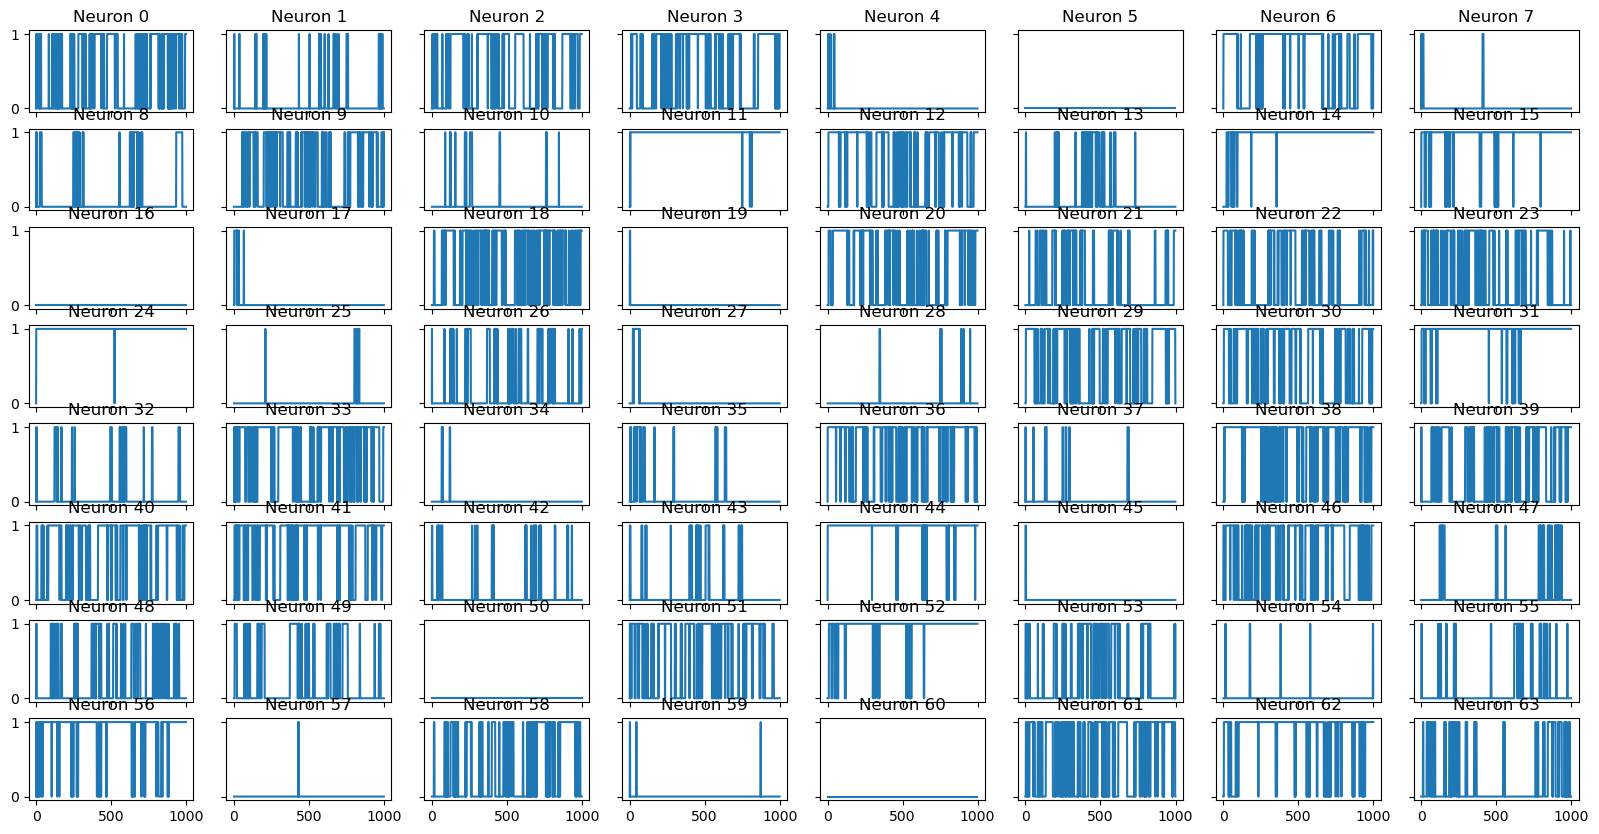

In [ ]:
# Plot spikes for all recurrent neurons
fig, axs = plt.subplots(8,8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(8):
    for j in range(8):
        axs[i,j].plot(net.z[:,0,i*8+j], label="output membrane voltage")
        axs[i,j].set_title(f"Neuron {i*8+j}")